## 3.7.2 High-Dimensional Linear Regression

합성 데이터를 이용한 weight decay 예제

In [4]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

다음과 같이 데이터를 생성

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

Overfitting 효과를 보여주기 위해 gaussian noise를 추가

In [7]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

## 3.7.3 Implementation from Scratch

Minibatch stochastic gradient descent 및 손실 함수에 $\ell_2$ penalty 추가

In [9]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

### 3.7.3.2 Defining the Model

이전에 사용한 regression 모델 및 loss에 penalty term을 포함

In [10]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.lambd * l2_penalty(self.w)

20개 훈련 데이터로 모델을 적합시키고, 100개의 검증 데이터로 모델을 평가

In [11]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

### 3.7.3.3 Training without Regularization

$\lambda = 0$ 으로 weight decay를 사용하지 않는 경우,
training error만 감소하여 overfitting

L2 norm of w: 0.011303705163300037


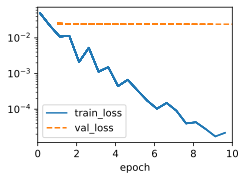

In [12]:
train_scratch(0)

### 3.7.3.4 Using Weight Decay

Weight decay를 사용하는 경우, validation error도 함께 감소

L2 norm of w: 0.0017761323833838105


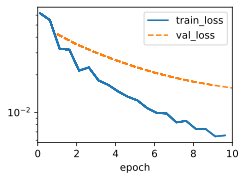

In [13]:
train_scratch(3)

<br/>
<br/>
<br/>
<br/>
<br/>

# 4. Linear Neural Networks for Classification

## 4.1 Softmax Regression


* how much? how many? $\rightarrow$  **Regression**
* which category? $\rightarrow$ **Classification**
    * 가입할 가능성이 높은 서비스
    * 다음에 볼 가능성이 가장 큰 영화
    * 이미지에 나타난 동물의 종류 


* Classification을 두 종류로 구분할 수 있지만, 모두 동일한 모델을 사용  
    1. 카테고리 자체만을 추정 (hard assignment)
    2. 각 카테고리의 가능성 추정 (soft assignment)


* 두 개 이상의 카테고리가 모두 속하는 경우 $\rightarrow$ **Multi-label Classification**
    * ex) 뉴스 기사가 포함하는 주제 (엔터테인먼트, 비즈니스 등)

### 4.1.1 Classification

예) 입력 이미지(2x2)에 대해 "cat", "chicken", "dog" 구별하기

* 예측하려는 카테고리에 순서 정보가 없다면 *one-hot encoding*으로 표현
* *one-hot encoding*은 카테고리 개수를 차원 수로 갖는 벡터이며, 해당 카테고리만 1로 설정, 나머지는 0
    * "cat": (1,0,0)
    * "chicken": (0,1,0)
    * "dog": (0,0,1)

#### 4.1.1.1 Linear Model

* 모든 카테고리에 대해 확률을 추정하기 위해, 12개의 $w$ (4개 feature x 3종류의 카테고리) 및 3개 $b$가 필요

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$

<br/>

* 다음과 같은 1개의 *fully connected layer*를 활용해 모델 구성 

![Softmax regression is a single-layer neural network.](http://d2l.ai/_images/softmaxreg.svg)


#### 4.1.1.2 The Softmax

* 단순하게 regression 하듯 출력 $o$와 $y$ 사이를 최소화할 수 있으며, 생각보다 잘 작동하지만 몇 가지 한계점이 존재
    * 각 출력을 확률로 간주하기 위해서 $o_i$ 의 합이 1이 되어야 함
    * 각 출력 $o_i$가 0 이상의 양수를 가져야 함  
    $\rightarrow$ 출력 값을 제한하도록 하는 계산이 필요
    
    
* 지수 함수 $P(y = i) \propto \exp o_i$ 를 사용해,
    * 확률 $o_i$가 증가함에 따라 연산 결과도 단조 증가하고,
    * 모든 결과가 양수를 가짐
    
    
* 각 값의 합을 나누어서 최대 값이 1이 되도록 변환 $\rightarrow$ **Softmax**

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o}) \quad \text{where}\quad \hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}$$

* *Softmax*의 결과는 크기 순서를 유지하기 때문에 카테고리 결정만을 위해서는 계산할 필요 없음

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

### 4.1.2 Loss Function


#### 4.1.2.1. Log-Likelihood
* 입력 feature $\mathbf{x}$가 주어졌을 때 softmax 결과는 각 카테고리의 확률로 해석 가능  
$$\hat{y}_1 = P(y=\text{cat} \mid \mathbf{x})$$


* 예측 확률과 실제 카테고리를 비교
$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).
$$
   
   
* 각 카테고리가 